# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('figure', figsize=(4, 3))

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [3]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [4]:
def numnull(series):
    return sum(series.isnull())

In [5]:
replace_invalid(gss)

### Variable `cappun`

Do you favor or oppose the death penalty for persons convicted of murder?

https://gssdataexplorer.norc.org/projects/41723/variables/268/vshow

In [6]:
numnull(gss.cappun)

AttributeError: 'DataFrame' object has no attribute 'cappun'

In [7]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [6]:
numnull(gss.gunlaw)

21994

In [7]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [8]:
numnull(gss.owngun)

24826

In [9]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
numnull(gss.gun)

43138

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [12]:
numnull(gss.natcrime)

28064

In [13]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [14]:
varname = 'income'
numnull(gss[varname])

7961

In [15]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [16]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [17]:
varname = 'realinc'
numnull(gss[varname])

6325

In [18]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [19]:
varname = 'educ'
numnull(gss[varname])

174

In [20]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [21]:
varname = 'polviews'
numnull(gss[varname])

9385

In [22]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [23]:
numnull(gss.age)

221

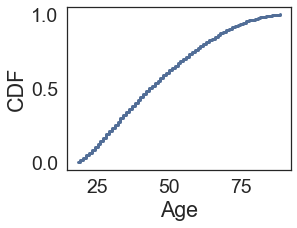

In [24]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [25]:
numnull(gss.cohort)

221

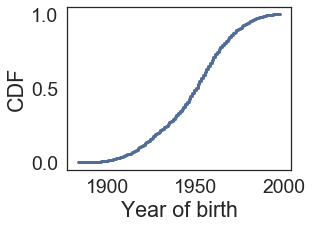

In [26]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [27]:
numnull(gss.sex)

0

In [28]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [29]:
numnull(gss.race)

0

In [30]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [31]:
numnull(gss.hispanic)

38149

In [32]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [33]:
numnull(gss.srcbelt)

0

In [34]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

### Make age and cohort groups

Group people into 5- and 10-year bins by birth year.

In [35]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [36]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()           # count cases where we have the dependent var
counts

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      14
2004.5     132
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [37]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [38]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

In [39]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [40]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     393
2000.0     132
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [41]:
utils.values(gss, 'year')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [42]:
gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
utils.values(gss, 'year4')

1971    3117
1975    6003
1979    3000
1983    6466
1987    6307
1991    4495
1995    5896
1999    5649
2003    5577
2007    6533
2011    4018
2015    5405
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [43]:
gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
utils.values(gss, 'age5')

17.5    1054
22.5    5283
27.5    6663
32.5    6784
37.5    6475
42.5    5924
47.5    5375
52.5    5007
57.5    4530
62.5    4047
67.5    3612
72.5    2955
77.5    2207
82.5    1381
87.5     948
92.5     221
Name: age5, dtype: int64

In [44]:
gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     840
85.5     573
88.5     591
91.5     221
Name: age3, dtype: int64

### Make booleans

In [45]:
def copy_nan(df, varname, newvar):
    df.loc[df[varname].isnull(), newvar] = np.nan

In [46]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [47]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    per25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= per25 
    copy_nan(df, 'realinc', 'lowrealinc')

    per75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= per75 
    copy_nan(df, 'realinc', 'highrealinc')

make_booleans(gss)

### Resample

In [48]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(62466, 56)

In [49]:
utils.values(sample, 'twenties')

0.0    56556
1.0     5910
Name: twenties, dtype: int64

In [50]:
utils.values(sample, 'thirties')

0.0    55565
1.0     6901
Name: thirties, dtype: int64

In [51]:
utils.values(sample, 'forties')

0.0    52183
1.0    10283
Name: forties, dtype: int64

In [52]:
utils.values(sample, 'fifties')

0.0    49413
1.0    13053
Name: fifties, dtype: int64

In [53]:
utils.values(sample, 'sixties')

0.0    52415
1.0    10051
Name: sixties, dtype: int64

In [54]:
utils.values(sample, 'seventies')

0.0    56316
1.0     6150
Name: seventies, dtype: int64

In [55]:
utils.values(sample, 'eighties')

0.0    59168
1.0     3298
Name: eighties, dtype: int64

In [56]:
utils.values(sample, 'nineties')

0.0    61621
1.0      845
Name: nineties, dtype: int64

In [57]:
utils.values(sample, 'favor')

0.0     9790
1.0    30986
Name: favor, dtype: int64

In [58]:
utils.values(sample, 'gunhome')

0.0    21709
1.0    16190
Name: gunhome, dtype: int64

In [59]:
utils.values(sample, 'threatened')

0.0    15584
1.0     3737
Name: threatened, dtype: int64

In [60]:
utils.values(sample, 'spendcrime')

0.0    11293
1.0    23239
Name: spendcrime, dtype: int64

In [61]:
utils.values(sample, 'topincome')

0.0    24057
1.0    29764
Name: topincome, dtype: int64

In [62]:
utils.values(sample, 'lowincome')

0.0    45266
1.0     8555
Name: lowincome, dtype: int64

In [63]:
utils.values(sample, 'lowrealinc')

0.0    43904
1.0    11574
Name: lowrealinc, dtype: int64

In [64]:
utils.values(sample, 'highrealinc')

0.0    39182
1.0    16296
Name: highrealinc, dtype: int64

In [65]:
utils.values(sample, 'liberal')

0.0    38976
1.0    14315
Name: liberal, dtype: int64

In [66]:
utils.values(sample, 'moderate')

0.0    32671
1.0    20620
Name: moderate, dtype: int64

In [67]:
utils.values(sample, 'conservative')

0.0    43476
1.0     9815
Name: conservative, dtype: int64

In [68]:
utils.values(sample, 'female')

0.0    28208
1.0    34258
Name: female, dtype: int64

In [69]:
utils.values(sample, 'ishisp')

0.0    22448
1.0     1876
Name: ishisp, dtype: int64

In [70]:
utils.values(sample, 'black')

0.0    54158
1.0     8308
Name: black, dtype: int64

In [71]:
utils.values(sample, 'otherrace')

0.0    58722
1.0     3744
Name: otherrace, dtype: int64

In [72]:
utils.values(sample, 'urban')

0.0    25239
1.0    37227
Name: urban, dtype: int64

In [73]:
utils.values(sample, 'suburban')

0.0    45395
1.0    17071
Name: suburban, dtype: int64

In [74]:
utils.values(sample, 'rural')

0.0    54298
1.0     8168
Name: rural, dtype: int64

In [75]:
utils.values(sample, 'college')

0.0    33348
1.0    28948
Name: college, dtype: int64

### Look at trends

In [76]:
def plot_series(grouped, varname, **options):
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options, label=varname)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

In [77]:
grouped_year4 = sample.groupby('year4')

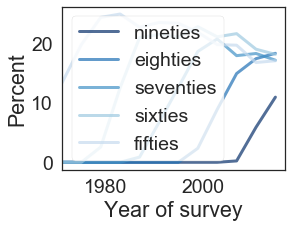

In [78]:
plot_series(grouped_year4, 'nineties')
plot_series(grouped_year4, 'eighties')
plot_series(grouped_year4, 'seventies')
plot_series(grouped_year4, 'sixties')
plot_series(grouped_year4, 'fifties')

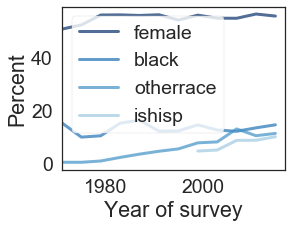

In [79]:
plot_series(grouped_year4, 'female')
plot_series(grouped_year4, 'black')
plot_series(grouped_year4, 'otherrace')
plot_series(grouped_year4, 'ishisp')

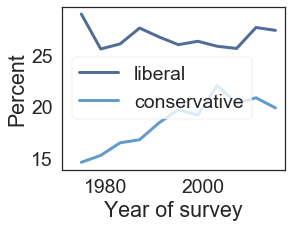

In [80]:
plot_series(grouped_year4, 'liberal')
plot_series(grouped_year4, 'conservative')

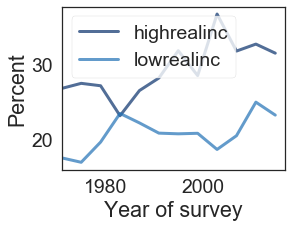

In [81]:
plot_series(grouped_year4, 'highrealinc')
plot_series(grouped_year4, 'lowrealinc')

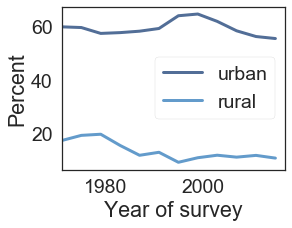

In [82]:
plot_series(grouped_year4, 'urban')
plot_series(grouped_year4, 'rural')

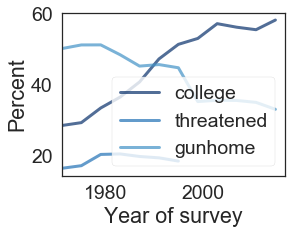

In [83]:
plot_series(grouped_year4, 'college')
plot_series(grouped_year4, 'threatened')
plot_series(grouped_year4, 'gunhome')

### Fill missing values

In [84]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [85]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [86]:
def fill_all_missing(df):
    varnames = ['year', 'cohort', 'owngun', 'gun', 'natcrime', 'income', 'realinc', 'educ',
                'polviews', 'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
    fill_age(df)

In [87]:
fill_all_missing(sample)

year 0
cohort 180
owngun 24567
gun 43145
natcrime 27934
income 8645
realinc 6988
educ 170
polviews 9175
sex 0
race 0
hispanic 38142
srcbelt 0
age 181


After filling, we have to make booleans again.

In [88]:
make_booleans(sample)

### Center cohort, age, and year.

In [89]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [90]:
center_factors(sample)

### Run logistic models



Drop records if we don't have the dependent variable.

In [91]:
subset = sample.dropna(subset=['gunlaw'])
subset.shape

(40776, 65)

How many records did we lose?

In [92]:
sample.shape[0] - subset.shape[0]

21690

In [93]:
subset.head()

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,highrealinc,ones,c,a,y,c2,a2,y2,y3,ac
0,1972,0.0,1928.0,0,1.3339,12.0,4,60915.0,2,0,...,1.0,1.0,-38.0,-3.0,-18,1444.0,9.0,324,-5832,114.0
2,1972,0.0,1930.0,0,0.8893,12.0,3,30458.0,1,0,...,0.0,1.0,-36.0,-5.0,-18,1296.0,25.0,324,-5832,180.0
3,1972,0.0,1946.0,0,0.8893,12.0,3,30458.0,2,0,...,0.0,1.0,-20.0,-21.0,-18,400.0,441.0,324,-5832,420.0
4,1972,0.0,1950.0,0,0.8893,9.0,5,4447.0,2,0,...,0.0,1.0,-16.0,-25.0,-18,256.0,625.0,324,-5832,400.0
5,1972,0.0,1933.0,0,1.3339,6.0,3,43994.0,2,0,...,1.0,1.0,-33.0,-8.0,-18,1089.0,64.0,324,-5832,264.0


In [94]:
sample.columns

Index(['year', 'conrinc', 'cohort', 'ballot', 'wtssall', 'income', 'finrela',
       'realinc', 'sex', 'homosex', 'hispanic', 'rowngun', 'owngun', 'id_',
       'age', 'race', 'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun',
       'gunage', 'gunnum', 'educ', 'cohort5', 'cohort10', 'year4', 'age5',
       'age3', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties', 'favor', 'gunhome', 'threatened',
       'spendcrime', 'topincome', 'lowincome', 'liberal', 'moderate',
       'conservative', 'female', 'ishisp', 'black', 'otherrace', 'urban',
       'suburban', 'rural', 'college', 'lowrealinc', 'highrealinc', 'ones',
       'c', 'a', 'y', 'c2', 'a2', 'y2', 'y3', 'ac'],
      dtype='object')

In [95]:
varnames = ['nineties', 'eighties', 'seventies', 'fifties', 'forties', 'thirties', 'twenties',
            'female', 'black', 'otherrace', 'ishisp', 'conservative', 'liberal', 'lowrealinc', 'highrealinc',
            'college', 'urban', 'rural', 'threatened', 'gunhome']

all_varnames = varnames + ['y', 'y2', 'y3', 'favor']

In [96]:
for varname in varnames:
    print(varname, sum(sample[varname].isnull()))

nineties 0
eighties 0
seventies 0
fifties 0
forties 0
thirties 0
twenties 0
female 0
black 0
otherrace 0
ishisp 0
conservative 0
liberal 0
lowrealinc 0
highrealinc 0
college 0
urban 0
rural 0
threatened 0
gunhome 0


Select just the columns we need

In [97]:
data = subset[all_varnames]
data.shape

(40776, 24)

In [98]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.506021
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40776
Model:                          Logit   Df Residuals:                    40752
Method:                           MLE   Df Model:                           23
Date:                Sat, 17 Mar 2018   Pseudo R-squ.:                 0.08194
Time:                        09:24:15   Log-Likelihood:                -20634.
converged:                       True   LL-Null:                       -22475.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5977      0.046     34.946      0.000       1.508       1.687
y                0.0326      0.002     13.682      0.000       0.028       0.037
y2           -8.944e-05      0.000     -0.851      0.395      -0.000       0.000
y3           -8.092e-05   6.82e-06    -11.866      0.000   -9.43e-05   -6.76e-05
nineties        -0.3388      0.106     -3.182      0.001      -0.547      -0.130
eighties        -0.2345      0.068     -3.465      0.001      -0.367      -0.102
seventies       -0.2061      0.052     -3.995      0.000      -0.307      -0.105
fifties         -0.0135      0.037     -0.369      0.712      -0.085       0.058
forties         -0.0019      0.039     -0.049      0.961      -0.078       0.074
thirties        -0.0866      0.043     -2.034      0.042      -0.170      -0.003
twenties        -0.0236      0.044     -0.531      0.595      -0.110       0.063
female           0.6814      0.025     27.594      0.000       0.633       0.730
black            0.1868      0.039      4.830      0.000       0.111       0.263
otherrace        0.4197      0.066      6.399      0.000       0.291       0.548
ishisp          -0.0116      0.046     -0.252      0.801      -0.102       0.079
conservative    -0.4011      0.031    -12.906      0.000      -0.462      -0.340
liberal          0.2114      0.030      7.006      0.000       0.152       0.271
lowrealinc      -0.1106      0.031     -3.562      0.000      -0.171      -0.050
highrealinc      0.0518      0.031      1.693      0.091      -0.008       0.112
college          0.1147      0.027      4.317      0.000       0.063       0.167
urban           -0.2507      0.030     -8.245      0.000      -0.310      -0.191
rural           -0.5124      0.041    -12.582      0.000      -0.592      -0.433
threatened      -0.1366      0.030     -4.524      0.000      -0.196      -0.077
gunhome         -0.8866      0.026    -34.377      0.000      -0.937      -0.836
================================================================================
"""

Make a row for someone in 2016 with all booleans false.

In [99]:
def make_base():
    y = 2016 - 1990
    y2 = y**2
    y3 = y**3

    d = dict(y=y, y2=y2, y3=y3)
    for varname in varnames:
        d[varname] = 0

    return pd.Series(d)

base = make_base()
base

black               0
college             0
conservative        0
eighties            0
female              0
fifties             0
forties             0
gunhome             0
highrealinc         0
ishisp              0
liberal             0
lowrealinc          0
nineties            0
otherrace           0
rural               0
seventies           0
thirties            0
threatened          0
twenties            0
urban               0
y                  26
y2                676
y3              17576
dtype: int64

Make a DataFrame that contains one row for each case we want to consider.

In [100]:
def make_df_pred():
    def add_yminus(df, varname, offset):
        """
    
        """
        df.loc[varname] = base
        df.loc[varname, 'y'] += offset
        df.loc[varname, 'y2'] = df.loc[varname, 'y']**2
        df.loc[varname, 'y3'] = df.loc[varname, 'y']**3
    
    base = make_base()
    df_pred = pd.DataFrame(columns=base.index, dtype=float)
    #df_pred = pd.DataFrame(columns=sample.columns)
    
    df_pred.loc['base'] = base

    for varname in varnames:
        df_pred.loc[varname] = base
        df_pred.loc[varname, varname] = 1
    
    add_yminus(df_pred, 'yminus10', -10)
    add_yminus(df_pred, 'yminus20', -20)
    add_yminus(df_pred, 'yminus30', -30)
    add_yminus(df_pred, 'yminus40', -40)
    
    df_pred.loc['lowest combo'] = base
    low_vars = ['gunhome', 'nineties', 'rural', 
                'conservative', 'lowrealinc', 'threatened']
    df_pred.loc['lowest combo', low_vars] = 1
    
    df_pred.loc['highest combo'] = base
    high_vars = ['female', 'otherrace', 'liberal', 
                'college', 'highrealinc']
    df_pred.loc['highest combo', high_vars] = 1
    
    return df_pred
    
df_pred = make_df_pred()
df_pred

,black,college,conservative,eighties,female,fifties,forties,gunhome,highrealinc,ishisp,...,otherrace,rural,seventies,thirties,threatened,twenties,urban,y,y2,y3
base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
nineties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
eighties,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
seventies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
fifties,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
forties,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
thirties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,676.0,17576.0
twenties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,676.0,17576.0
female,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0
black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,17576.0


In [101]:
pred = model.predict(df_pred) * 100
pred

base             72.386875
nineties         65.133715
eighties         67.462738
seventies        68.085042
fifties          72.115497
forties          72.349018
thirties         70.623550
twenties         71.913454
female           83.823420
black            75.960798
otherrace        79.954658
ishisp           72.153802
conservative     63.707053
liberal          76.407622
lowrealinc       70.123153
highrealinc      73.410560
college          74.619695
urban            67.107425
rural            61.096021
threatened       69.575569
gunhome          51.927329
yminus10         85.392112
yminus20         85.481710
yminus30         81.319124
yminus40         79.334360
lowest combo     19.430804
highest combo    92.003474
dtype: float64

In [102]:
pred - pred['base']

base              0.000000
nineties         -7.253159
eighties         -4.924136
seventies        -4.301833
fifties          -0.271378
forties          -0.037857
thirties         -1.763324
twenties         -0.473421
female           11.436545
black             3.573923
otherrace         7.567784
ishisp           -0.233073
conservative     -8.679822
liberal           4.020747
lowrealinc       -2.263722
highrealinc       1.023686
college           2.232820
urban            -5.279450
rural           -11.290854
threatened       -2.811306
gunhome         -20.459546
yminus10         13.005238
yminus20         13.094836
yminus30          8.932249
yminus40          6.947485
lowest combo    -52.956071
highest combo    19.616599
dtype: float64

In [103]:
def make_result(pred):
    result = pd.DataFrame()
    result['pred'] = pred
    result['offset'] = pred - pred['base']
    return result

result = make_result(pred)
result

,pred,offset
base,72.386875,0.000000
nineties,65.133715,-7.253159
eighties,67.462738,-4.924136
seventies,68.085042,-4.301833
fifties,72.115497,-0.271378
forties,72.349018,-0.037857
thirties,70.623550,-1.763324
twenties,71.913454,-0.473421
female,83.823420,11.436545
black,75.960798,3.573923


### Iterate

In [104]:
def run(iters=101):
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    
    results = []
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        data = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=data).fit()

        df_pred = make_df_pred()
        pred = model.predict(df_pred) * 100
        result = make_result(pred)
        
        results.append(result)
    return results

In [105]:
results = run()

year 0
cohort 191
owngun 24786
gun 43179
natcrime 27886
income 8527
realinc 6888
educ 179
polviews 9259
sex 0
race 0
hispanic 38146
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.504094
         Iterations 6
year 0
cohort 176
owngun 24918
gun 43056
natcrime 28038
income 8526
realinc 6896
educ 159
polviews 9370
sex 0
race 0
hispanic 38165
srcbelt 0
age 177
Optimization terminated successfully.
         Current function value: 0.506130
         Iterations 6
year 0
cohort 188
owngun 24739
gun 43122
natcrime 28039
income 8470
realinc 6811
educ 186
polviews 9301
sex 0
race 0
hispanic 38146
srcbelt 0
age 190
Optimization terminated successfully.
         Current function value: 0.502178
         Iterations 6
year 0
cohort 200
owngun 24972
gun 43128
natcrime 27997
income 8395
realinc 6722
educ 196
polviews 9349
sex 0
race 0
hispanic 38155
srcbelt 0
age 199
Optimization terminated successfully.
         Current function value: 0.504286
         Itera

Optimization terminated successfully.
         Current function value: 0.506560
         Iterations 6
year 0
cohort 192
owngun 24935
gun 43136
natcrime 27776
income 8595
realinc 6961
educ 166
polviews 9370
sex 0
race 0
hispanic 38149
srcbelt 0
age 194
Optimization terminated successfully.
         Current function value: 0.501964
         Iterations 6
year 0
cohort 180
owngun 24807
gun 43090
natcrime 28039
income 8521
realinc 6875
educ 154
polviews 9218
sex 0
race 0
hispanic 38146
srcbelt 0
age 179
Optimization terminated successfully.
         Current function value: 0.503475
         Iterations 6
year 0
cohort 193
owngun 25010
gun 43037
natcrime 28081
income 8565
realinc 6907
educ 167
polviews 9202
sex 0
race 0
hispanic 38155
srcbelt 0
age 193
Optimization terminated successfully.
         Current function value: 0.503540
         Iterations 6
year 0
cohort 183
owngun 24851
gun 43127
natcrime 27861
income 8373
realinc 6729
educ 181
polviews 9316
sex 0
race 0
hispanic 38150
srcbelt 0


income 8399
realinc 6783
educ 140
polviews 9268
sex 0
race 0
hispanic 38146
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.500192
         Iterations 6
year 0
cohort 190
owngun 24750
gun 43146
natcrime 27923
income 8584
realinc 6929
educ 157
polviews 9319
sex 0
race 0
hispanic 38142
srcbelt 0
age 189
Optimization terminated successfully.
         Current function value: 0.502295
         Iterations 6
year 0
cohort 185
owngun 24728
gun 43088
natcrime 28060
income 8370
realinc 6715
educ 149
polviews 9324
sex 0
race 0
hispanic 38155
srcbelt 0
age 182
Optimization terminated successfully.
         Current function value: 0.502775
         Iterations 6
year 0
cohort 195
owngun 24842
gun 43137
natcrime 28097
income 8422
realinc 6802
educ 153
polviews 9269
sex 0
race 0
hispanic 38147
srcbelt 0
age 193
Optimization terminated successfully.
         Current function value: 0.503244
         Iterations 6
year 0
cohort 193
owngun 24877
gun 43210
natcrim

income 8561
realinc 6903
educ 164
polviews 9294
sex 0
race 0
hispanic 38155
srcbelt 0
age 203
Optimization terminated successfully.
         Current function value: 0.503961
         Iterations 6
year 0
cohort 198
owngun 24679
gun 43208
natcrime 27880
income 8321
realinc 6679
educ 178
polviews 9310
sex 0
race 0
hispanic 38161
srcbelt 0
age 198
Optimization terminated successfully.
         Current function value: 0.502453
         Iterations 6
year 0
cohort 173
owngun 24735
gun 43118
natcrime 27806
income 8437
realinc 6783
educ 150
polviews 9239
sex 0
race 0
hispanic 38136
srcbelt 0
age 172
Optimization terminated successfully.
         Current function value: 0.506078
         Iterations 6


In [106]:
preds = [result.pred for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 5, 95])

estimates = pd.DataFrame(index=result.index)
estimates['low2.5'] = low
estimates['median'] = median
estimates['high97.5'] = high
estimates.round(1)

,low2.5,median,high97.5
base,71.4,73.6,75.5
nineties,59.9,63.9,68.1
eighties,65.2,67.7,70.4
seventies,67.8,70.2,72.2
fifties,70.9,72.9,75.2
forties,71.5,73.7,75.9
thirties,70.1,72.1,74.9
twenties,70.9,73.2,75.2
female,83.5,84.7,86.0
black,76.3,78.0,80.3


In [107]:
lines = estimates.round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>base</th>
      <td>71.4</td>
      <td>73.6</td>
      <td>75.5</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>59.9</td>
      <td>63.9</td>
      <td>68.1</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>65.2</td>
      <td>67.7</td>
      <td>70.4</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>67.8</td>
      <td>70.2</td>
      <td>72.2</td>
    </tr>
    <tr>
      <th>fifties</th>
      <td>70.9</td>
      <td>72.9</td>
      <td>75.2</td>
    </tr>
    <tr>
      <th>forties</th>
      <td>71.5</td>
      <td>73.7</td>
      <td>75.9</td>
    </tr>
    <tr>
      <th>thirties</th>
      <td>70.1</td>
      <td>72.1</td>
      <td>74.9</td>
    </tr>
    <tr>
      <th>twenties</th>
      <td>70.9</td>
      <td>73.2</td>
      <td>75.

In [108]:
preds = [result.offset for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 2.5, 97.5])

offsets = pd.DataFrame(index=result.index)
offsets['low2.5'] = low
offsets['median'] = median
offsets['high97.5'] = high
offsets.sort_values('median').round(1)

,low2.5,median,high97.5
lowest combo,-58.6,-54.6,-50.7
gunhome,-21.5,-20.1,-18.5
rural,-13.4,-11.5,-9.4
nineties,-14.8,-9.8,-4.8
conservative,-8.9,-7.6,-6.2
eighties,-8.5,-6.0,-3.6
urban,-6.5,-5.4,-4.2
seventies,-5.7,-3.5,-1.8
threatened,-3.4,-2.3,-0.9
lowrealinc,-3.7,-2.2,-0.9


In [109]:
lines = offsets.sort_values('median').round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>lowest combo</th>
      <td>-58.6</td>
      <td>-54.6</td>
      <td>-50.7</td>
    </tr>
    <tr>
      <th>gunhome</th>
      <td>-21.5</td>
      <td>-20.1</td>
      <td>-18.5</td>
    </tr>
    <tr>
      <th>rural</th>
      <td>-13.4</td>
      <td>-11.5</td>
      <td>-9.4</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>-14.8</td>
      <td>-9.8</td>
      <td>-4.8</td>
    </tr>
    <tr>
      <th>conservative</th>
      <td>-8.9</td>
      <td>-7.6</td>
      <td>-6.2</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>-8.5</td>
      <td>-6.0</td>
      <td>-3.6</td>
    </tr>
    <tr>
      <th>urban</th>
      <td>-6.5</td>
      <td>-5.4</td>
      <td>-4.2</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>-5.7</td>
      <td>-3.5</t

### Retrodict trends

In [110]:
def predict_favor(df, model):
    """Predict the percentage of people who would favor struct gun laws.
    
    df: DataFrame
    model: model
    
    return: percentage
    """
    probs = model.predict(df)
    bools = np.random.random(len(probs)) < probs
    assert numnull(bools) == 0
    return bools.dropna().mean() * 100

In [111]:
subset.favor.mean(), predict_favor(data, model)

(0.7599077888954286, 76.329213262703561)

In [112]:
sample.favor.mean(), predict_favor(sample, model)

(0.7599077888954286, 76.411167675215324)

In [113]:
grouped_year4 = sample.groupby('year')

In [114]:
for name, group in grouped_year4:
    retro = predict_favor(group, model)
    actual = group.favor.mean() * 100
    print(name, len(group), actual, retro)

1972 1613 70.9242618741977 73.5895846249
1973 1504 75.03392130257802 73.2712765957
1974 1484 74.65940054495913 70.9568733154
1975 1490 73.88008270158511 72.6845637584
1976 1499 70.97428958051421 71.7144763175
1977 1530 71.31474103585657 69.477124183
1978 1532 nan 72.0626631854
1980 1468 68.23204419889503 73.3651226158
1982 1860 75.12328767123287 71.8817204301
1983 1599 nan 72.9205753596
1984 1473 69.80474198047419 73.7270875764
1985 1534 74.58745874587459 73.5984354628
1986 1470 nan 76.2585034014
1987 1819 72.11538461538461 76.745464541
1988 1481 77.07267144319346 75.3544902093
1989 1537 79.39086294416244 76.903057905
1990 1372 79.24743443557583 79.1545189504
1991 1517 79.55689828801611 78.6420566908
1993 1606 82.57713248638838 79.8879202989
1994 2992 78.35820895522389 79.7125668449
1996 2904 82.27984873041599 80.7851239669
1998 2832 83.61884368308351 83.0508474576
2000 2817 80.97055616139586 81.4341498048
2002 2765 80.35902851108764 81.4466546112
2004 2812 81.71806167400881 79.9431009

In [166]:
def make_result(sample, model):
    actual = pd.Series([])
    retro = pd.Series([])
    grouped_year4 = sample.groupby('year')
    for name, group in grouped_year4:
        retro[name] = predict_favor(group, model)
        actual[name] = group.favor.mean() * 100

    result = pd.DataFrame()
    result['actual'] = actual
    result['retro'] = retro
    result['residual'] = retro - actual
    
    return result

In [167]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [168]:
result = make_result(sample, model)

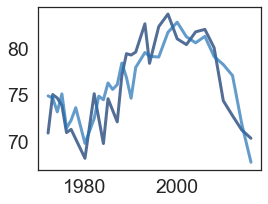

In [169]:
plot_series(result.actual)
plot_series(result.retro)

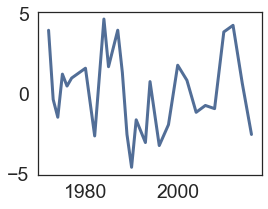

In [170]:
plot_series(result.residual)

In [180]:
# TODO: take formula as a parameter

def run(formula, iters=201):
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    
    results = []
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        data = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=data).fit()

        result = make_result(sample, model)
        
        results.append(result)
    return results

In [212]:
formula = ('favor ~ y + y2 + y3 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
#formula = ('favor ~ y + y2 + y3')
results = run(formula)

year 0
cohort 193
owngun 25034
gun 43090
natcrime 28006
income 8487
realinc 6845
educ 175
polviews 9276
sex 0
race 0
hispanic 38164
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.503246
         Iterations 6
year 0
cohort 174
owngun 24750
gun 43197
natcrime 27916
income 8457
realinc 6827
educ 150
polviews 9229
sex 0
race 0
hispanic 38146
srcbelt 0
age 175
Optimization terminated successfully.
         Current function value: 0.501968
         Iterations 6
year 0
cohort 194
owngun 24857
gun 43116
natcrime 27964
income 8396
realinc 6767
educ 145
polviews 9223
sex 0
race 0
hispanic 38158
srcbelt 0
age 194
Optimization terminated successfully.
         Current function value: 0.500452
         Iterations 6
year 0
cohort 193
owngun 24766
gun 43127
natcrime 27737
income 8404
realinc 6786
educ 181
polviews 9301
sex 0
race 0
hispanic 38153
srcbelt 0
age 193
Optimization terminated successfully.
         Current function value: 0.503266
         Itera

Optimization terminated successfully.
         Current function value: 0.505901
         Iterations 6
year 0
cohort 158
owngun 24813
gun 43100
natcrime 27962
income 8494
realinc 6857
educ 167
polviews 9210
sex 0
race 0
hispanic 38155
srcbelt 0
age 159
Optimization terminated successfully.
         Current function value: 0.500545
         Iterations 6
year 0
cohort 174
owngun 24565
gun 43241
natcrime 27785
income 8438
realinc 6757
educ 155
polviews 9298
sex 0
race 0
hispanic 38148
srcbelt 0
age 176
Optimization terminated successfully.
         Current function value: 0.501749
         Iterations 6
year 0
cohort 198
owngun 24658
gun 43191
natcrime 27993
income 8480
realinc 6824
educ 165
polviews 9340
sex 0
race 0
hispanic 38155
srcbelt 0
age 200
Optimization terminated successfully.
         Current function value: 0.506112
         Iterations 6
year 0
cohort 185
owngun 24827
gun 43175
natcrime 27947
income 8432
realinc 6766
educ 151
polviews 9305
sex 0
race 0
hispanic 38150
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.508488
         Iterations 6
year 0
cohort 186
owngun 24882
gun 43112
natcrime 28013
income 8394
realinc 6737
educ 176
polviews 9197
sex 0
race 0
hispanic 38152
srcbelt 0
age 187
Optimization terminated successfully.
         Current function value: 0.505934
         Iterations 6
year 0
cohort 195
owngun 24702
gun 43076
natcrime 27954
income 8542
realinc 6922
educ 162
polviews 9245
sex 0
race 0
hispanic 38153
srcbelt 0
age 195
Optimization terminated successfully.
         Current function value: 0.504020
         Iterations 6
year 0
cohort 183
owngun 24875
gun 43118
natcrime 27921
income 8384
realinc 6755
educ 184
polviews 9252
sex 0
race 0
hispanic 38151
srcbelt 0
age 183
Optimization terminated successfully.
         Current function value: 0.505535
         Iterations 6
year 0
cohort 179
owngun 24889
gun 43144
natcrime 28141
income 8453
realinc 6787
educ 165
polviews 9223
sex 0
race 0
hispanic 38150
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.500807
         Iterations 6
year 0
cohort 179
owngun 24875
gun 43077
natcrime 27885
income 8503
realinc 6869
educ 181
polviews 9328
sex 0
race 0
hispanic 38146
srcbelt 0
age 179
Optimization terminated successfully.
         Current function value: 0.499959
         Iterations 6
year 0
cohort 177
owngun 24828
gun 43163
natcrime 28082
income 8517
realinc 6834
educ 164
polviews 9376
sex 0
race 0
hispanic 38153
srcbelt 0
age 177
Optimization terminated successfully.
         Current function value: 0.505600
         Iterations 6
year 0
cohort 191
owngun 24839
gun 43172
natcrime 27910
income 8548
realinc 6932
educ 158
polviews 9402
sex 0
race 0
hispanic 38158
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.501547
         Iterations 6
year 0
cohort 216
owngun 24869
gun 43100
natcrime 28197
income 8332
realinc 6723
educ 168
polviews 9325
sex 0
race 0
hispanic 38155
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.501662
         Iterations 6
year 0
cohort 211
owngun 24814
gun 43160
natcrime 28130
income 8375
realinc 6739
educ 159
polviews 9344
sex 0
race 0
hispanic 38152
srcbelt 0
age 213
Optimization terminated successfully.
         Current function value: 0.502979
         Iterations 6
year 0
cohort 188
owngun 25047
gun 43141
natcrime 27978
income 8322
realinc 6689
educ 168
polviews 9218
sex 0
race 0
hispanic 38145
srcbelt 0
age 188
Optimization terminated successfully.
         Current function value: 0.506170
         Iterations 6
year 0
cohort 176
owngun 24841
gun 43120
natcrime 27986
income 8397
realinc 6740
educ 175
polviews 9327
sex 0
race 0
hispanic 38154
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.503791
         Iterations 6
year 0
cohort 198
owngun 24718
gun 43139
natcrime 27883
income 8360
realinc 6699
educ 143
polviews 9351
sex 0
race 0
hispanic 38154
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.500487
         Iterations 6
year 0
cohort 205
owngun 24919
gun 43164
natcrime 28086
income 8654
realinc 7023
educ 177
polviews 9382
sex 0
race 0
hispanic 38150
srcbelt 0
age 207
Optimization terminated successfully.
         Current function value: 0.510596
         Iterations 6
year 0
cohort 177
owngun 24852
gun 43187
natcrime 27967
income 8412
realinc 6763
educ 169
polviews 9236
sex 0
race 0
hispanic 38155
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.503922
         Iterations 6
year 0
cohort 192
owngun 24617
gun 43215
natcrime 27792
income 8509
realinc 6851
educ 156
polviews 9188
sex 0
race 0
hispanic 38146
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.502115
         Iterations 6
year 0
cohort 182
owngun 24780
gun 43101
natcrime 27767
income 8557
realinc 6896
educ 175
polviews 9384
sex 0
race 0
hispanic 38147
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.503077
         Iterations 6
year 0
cohort 212
owngun 24859
gun 43147
natcrime 27967
income 8632
realinc 7008
educ 168
polviews 9344
sex 0
race 0
hispanic 38146
srcbelt 0
age 212
Optimization terminated successfully.
         Current function value: 0.501232
         Iterations 6
year 0
cohort 198
owngun 24704
gun 43069
natcrime 28129
income 8491
realinc 6841
educ 179
polviews 9262
sex 0
race 0
hispanic 38148
srcbelt 0
age 198
Optimization terminated successfully.
         Current function value: 0.504055
         Iterations 6
year 0
cohort 183
owngun 24712
gun 43148
natcrime 27931
income 8551
realinc 6897
educ 171
polviews 9316
sex 0
race 0
hispanic 38143
srcbelt 0
age 184
Optimization terminated successfully.
         Current function value: 0.501946
         Iterations 6


In [213]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [214]:
def get_percentiles(results, varname, ps=None):
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    ps = np.asarray(ps)
    series_seq = [result[varname] for result in results]
    xs, rows = percentile_rows(series_seq, ps)
    return xs, rows

In [215]:
def plot_percentiles(results, varname, color, label, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    results: list of DataFrames
    varname: string variable names
    color: string color
    label: string label
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    xs, rows = get_percentiles(results, varname)
    if fill:
        thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
    if plot:
        thinkplot.plot(xs, rows[1], color=color, label=label)

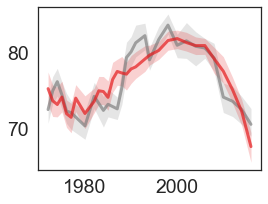

In [216]:
plot_percentiles(results, 'actual', 'gray', 'actual')
plot_percentiles(results, 'retro', RED, 'retro')

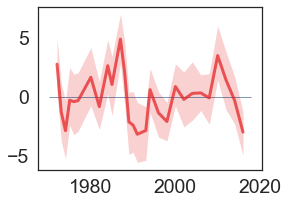

In [217]:
# TODO: remember how to draw hlines without specifying x1 and x2
thinkplot.hlines(0, 1970, 2018)
plot_percentiles(results, 'residual', RED, 'residual')

In [218]:
xs, rows = get_percentiles(results, 'residual')
abs(rows[1]).mean()

1.6353184506850853

### Test counterfactual code

In [ ]:
# may not need this any more, since sample is a copy
counterfact = sample.copy()

In [ ]:
def flip(df, varname, val, new_val, prob):
    """Changes the value of a variable for a random sample of rows.
    
    Selects each row where varname==val with probability prob, and
    replaces val with new_val.
    
    df: DataFrame
    varname: string
    val: old value
    new_val: new value
    prob: probability of flipping
    """
    assert(0 < prob < 1)
    #print('flip', val, new_val, prob)
    
    # get indices of the rows that match val
    indices = np.flatnonzero(df[varname] == val)
    #print(len(indices) * prob)
    
    # flip a coin for each selected row
    cond = np.random.random(len(indices)) < prob

    # get indices of the rows that will flip
    flippers = indices[cond]
    #print(len(flippers))
    #print((df.loc[flippers, varname] == val).mean())
    
    # assign the new val to the selected rows
    labels = df.index[flippers]
    df.loc[labels, varname] = new_val

In [ ]:
counterfact.college.value_counts()

In [ ]:
flip(counterfact, 'college', 1, 0, 0.1)

In [ ]:
counterfact.college.value_counts()

In [ ]:
def adjust_prob(df, varname, desired):
    """Flip enough people to make the mean of varname equal desired.

    varname must be a 0,1 boolean

    Can only reliably make small changes.

    df: DataFrame
    varname: string column name
    desired: value between 0 and 1
    """
    actual = df[varname].mean()
    diff = desired - actual
    #print(actual, diff)
    if diff > 0:
        prob = diff / (1-actual)
        flip(df, varname, 0, 1, prob)
    elif diff < 0:
        prob = -diff / actual
        flip(df, varname, 1, 0, prob)

In [ ]:
counterfact.college.value_counts()

In [ ]:
adjust_prob(counterfact, 'college', 0.9)

In [ ]:
counterfact.college.value_counts()

In [ ]:
counterfact.college.mean()

In [ ]:
def make_counterfactual(grouped, varname, desired):
    """Modifies a groupby so the proportion of varname is constant.
    
    grouped: groupby object
    varname: string column name
    desired: value to level out at
    """
    for name, group in grouped:
        before = group[varname].mean() * 100
        adjust_prob(group, varname, desired)
        after = group[varname].mean() * 100

        print(name, before, after)

In [ ]:
counterfact = sample.copy()

In [ ]:
grouped_year4 = counterfact.groupby('year')
grouped_year4.black.mean()

In [ ]:
prob = grouped_year4.black.mean()[1973]
prob

In [ ]:
make_counterfactual(grouped_year4, 'black', prob)

In [ ]:
predict_favor(counterfact, model)

In [ ]:
actual = pd.Series([])
counter = pd.Series([])
for name, group in grouped_year4:
    counter[name] = predict_favor(group, model)
    actual[name] = group.favor.mean() * 100

thinkplot.plot(actual.index, actual)
thinkplot.plot(retro.index, retro)
thinkplot.plot(counter.index, counter)

### Run counterfactuals

## Favor gunlaw

In [ ]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

In [ ]:
def plot_gunlaw(grouped):
    """.
    
    grouped:
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [ ]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor')
favor

In [ ]:
plot_series(favor, color=BLUE, label='favor')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
crime = make_series(grouped_year, 'crime')
crime

In [ ]:
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
plot_series(favor, color=BLUE, label='favor')
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(title='Support for gun control and concern about crime',
                 xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
grouped_age = sample.groupby(['age_group'])

In [ ]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [ ]:
grouped_cohort = sample.groupby(['cohort5'])

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri.year

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

In [ ]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year4'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year4')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)